# ARMA

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import math

import wrds
import fredapi

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox as LjungBox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
Fred_API_key_string = 'd8ddc8303a6b307530c7e17895e6eeed'

Total business inventories (seasonally adjusted numbers, monthly). 

This series is closely followed because it is a current indicator of consumer demand, and a leading indicator of businesses' forecasts of that demand.

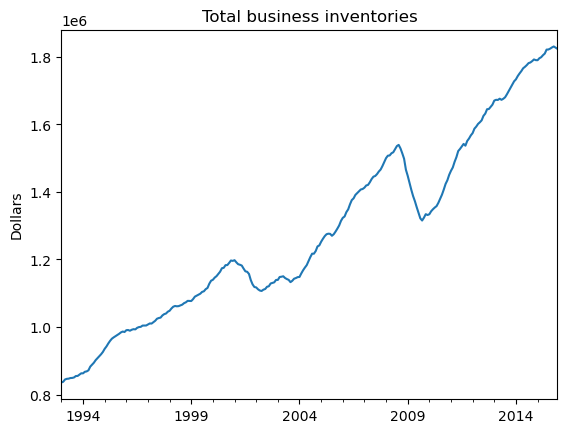

In [3]:
BUSINV = fredapi.Fred(api_key=Fred_API_key_string).get_series('BUSINV', observation_start = '1993-01-01', observation_end = '2015-12-31' )
BUSINV.index = pd.DatetimeIndex(BUSINV.index.values,freq='MS')
BUSINV.plot(title="Total business inventories",ylabel="Dollars");

We will model the growth rate of these inventories, calculated in the usual way:

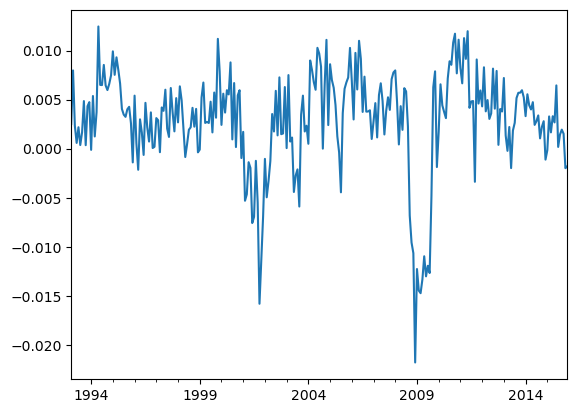

In [4]:
BUSINV_growth = np.log(BUSINV).diff().dropna()
BUSINV_growth.plot();

Save two datasets of this growth rate for use in our analysis: 
- A "training" dataset that ends in 2010. Use this to estimate and assess the models.
- A "test" dataset that runs from 2011-2015. Use this dataset to assess the out-of-sample forecasts that you make with the estimated models.

In [5]:
BUSINV_growth_training = BUSINV_growth[:'2010']

BUSINV_growth_test = BUSINV_growth['2011':'2015']

1. Check that the "training" data appear stationary using our usual tests.
2. Consider three models for the "training" data: AR(1), MA(1), and ARMA(1,1). Use the Box-Jenkins approach (as described in class) to select one of the three models as the best for this data.
3. For all three of the models mentioned above, plot forecasts through the end of 2015 (60 months beyond the end of the training data), along with prediction intervals at the usual 95% confidence level, and plot in the same figure the actual values in the "testing" data. 
4. What explains the different visual shapes of the forecasts? Which model seems most appropriate, just based on looking at the predictions visually? Which model performs the best in terms of RMSE during the testing period? 

ADF test results for training data:


(-4.487323039041556,
 0.00020727560587595602,
 9,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 -1669.6633163206589)

KPSS test results for training data:


/var/folders/m5/g3lrdtg540gfc8q3_268l1800000gn/T/ipykernel_27719/2319994965.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  display(kpss(BUSINV_growth_training))


(0.11511842042656542,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

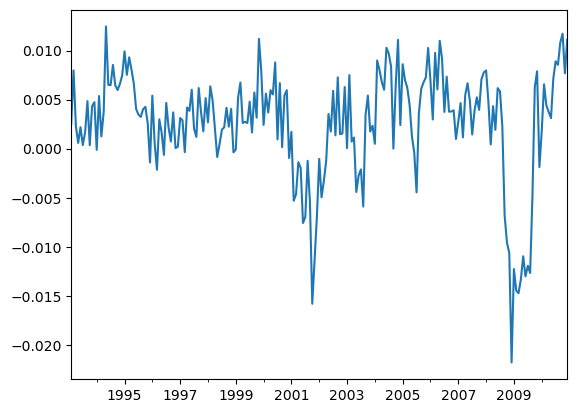

In [6]:
BUSINV_growth_training.plot();
print("ADF test results for training data:")
display(adfuller(BUSINV_growth_training))
print("KPSS test results for training data:")
display(kpss(BUSINV_growth_training))

we find that the training data is statinoary from both ADF test and KPSS test.

In [7]:
print("Ljung-Box test on BUSINV growth training:")
print( LjungBox( BUSINV_growth_training , lags=1) )

Ljung-Box test on BUSINV growth training:
      lb_stat     lb_pvalue
1  119.487612  8.190525e-28


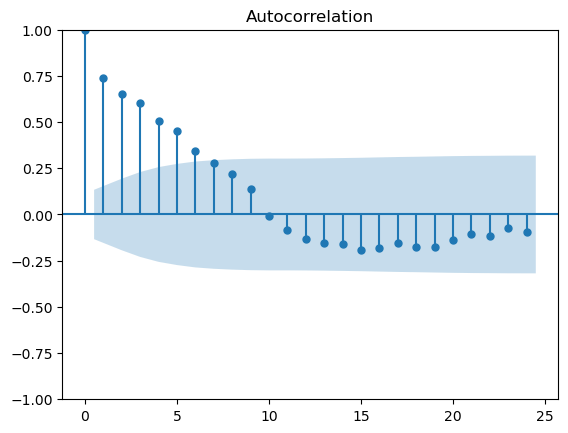

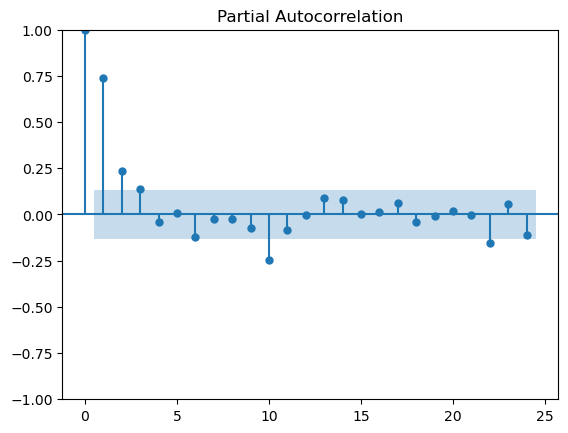

In [8]:
plot_acf(BUSINV_growth_training);
plot_pacf(BUSINV_growth_training);

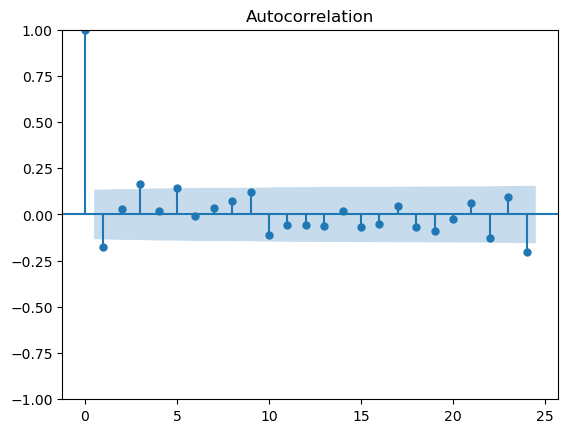

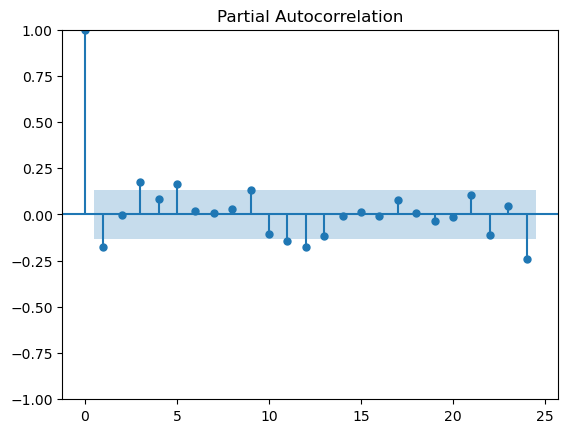

In [9]:
AR1_model = ARIMA(BUSINV_growth_training,order=(1,0,0)).fit()
plot_acf(AR1_model.resid);
plot_pacf(AR1_model.resid);

In [10]:
print("Ljung-Box test on residuals from AR1 model:")
print( LjungBox( AR1_model.resid , lags=1) )

Ljung-Box test on residuals from AR1 model:
    lb_stat  lb_pvalue
1  6.708494   0.009595


/Users/siyuanwang/anaconda3/envs/maf657/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


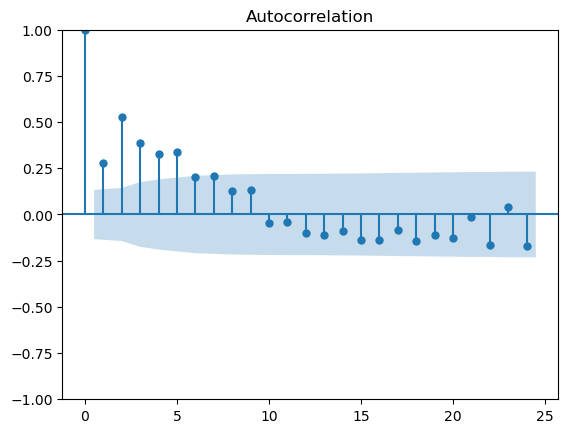

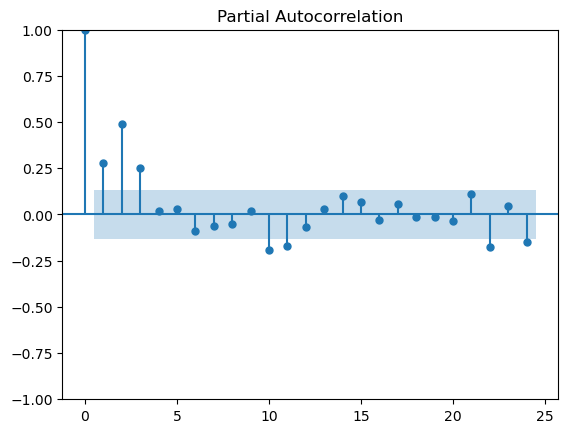

In [11]:
MA1_model = ARIMA(BUSINV_growth_training,order=(0,0,1)).fit()
plot_acf(MA1_model.resid);
plot_pacf(MA1_model.resid);

In [12]:
print("Ljung-Box test on residuals from MA1 model:")
print( LjungBox( MA1_model.resid , lags=1) )

Ljung-Box test on residuals from MA1 model:
     lb_stat  lb_pvalue
1  16.892322    0.00004


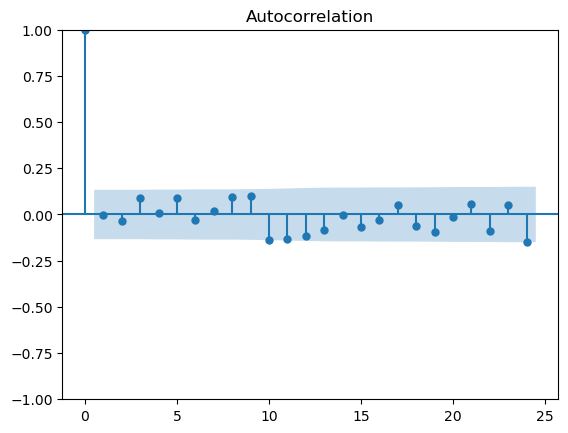

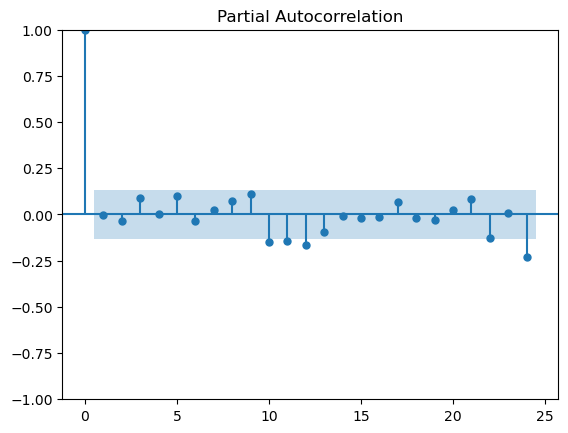

In [13]:
ARMA1_model = ARIMA(BUSINV_growth_training,order=(1,0,1)).fit()
plot_acf(ARMA1_model.resid);
plot_pacf(ARMA1_model.resid);

In [14]:
print("Ljung-Box test on residuals from ARMA1 model:")
print( LjungBox( ARMA1_model.resid , lags=1) )

Ljung-Box test on residuals from ARMA1 model:
   lb_stat  lb_pvalue
1  0.00346   0.953097


From the LB test, we find the ARMA model is the best for this data, since the p-value comes to large. 

For AR model:

In [15]:
AR1_model_forecasts = AR1_model.forecast(60)

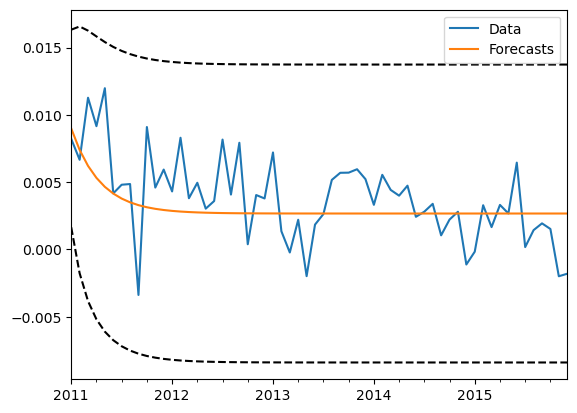

In [16]:
BUSINV_growth_test.plot(legend=True,label="Data");
AR1_forecasts_frame = AR1_model.get_forecast(60).summary_frame()
AR1_forecasts_frame['mean'].plot(legend=True,label="Forecasts");
AR1_forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
AR1_forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

For MA model:

In [17]:
MA1_model_forecasts = MA1_model.forecast(60)

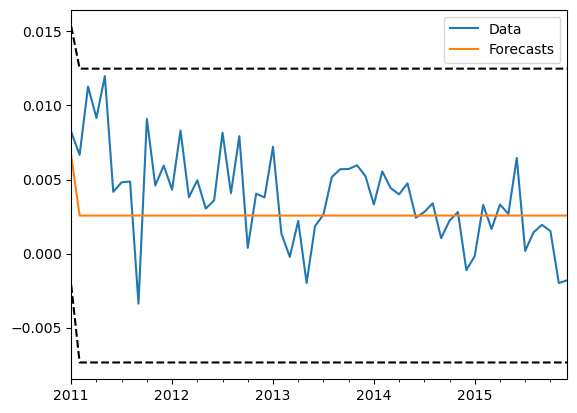

In [18]:
BUSINV_growth_test.plot(legend=True,label="Data");
MA1_forecasts_frame = MA1_model.get_forecast(60).summary_frame()
MA1_forecasts_frame['mean'].plot(legend=True,label="Forecasts");
MA1_forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
MA1_forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

For ARMA model:

In [19]:
ARMA1_model_forecasts = ARMA1_model.forecast(60)

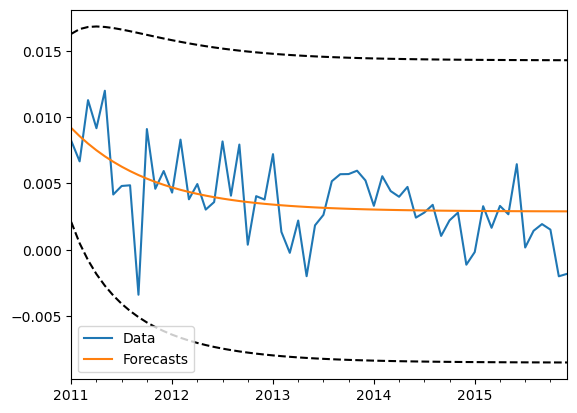

In [20]:
BUSINV_growth_test.plot(legend=True,label="Data");
ARMA1_forecasts_frame = ARMA1_model.get_forecast(60).summary_frame()
ARMA1_forecasts_frame['mean'].plot(legend=True,label="Forecasts");
ARMA1_forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
ARMA1_forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

Because AR, MA, and ARMA processes are different simulation are the original data, and AR, MA, ARMA processes estimate data in different ways. AR process do regression for the data, but MA, and ARMA process do MLE for the data. Therefore, we find different visual shapes of the forecasts. If we just based on looking at the prediction visually, I think both AR, and ARMA model seems approprate.

In [21]:
def RMSE(data, forecast):
    rmse = np.sqrt(np.mean((np.array(data)-np.array(forecast)) ** 2))
    return rmse

print(f"RMSE value for AR1: {RMSE(BUSINV_growth_test, AR1_model_forecasts)}")
print(f"RMSE value for MA1: {RMSE(BUSINV_growth_test, MA1_model_forecasts)}")
print(f"RMSE value for ARMA1: {RMSE(BUSINV_growth_test, ARMA1_model_forecasts)}")

RMSE value for AR1: 0.0028942116789009544
RMSE value for MA1: 0.003305618287538458
RMSE value for ARMA1: 0.002647299216749266


So the RMSE value for ARMA1 is the lowest, which is the best one. And the following code is added after announcement.

In [25]:
forecast_errors = BUSINV_growth_test - ARMA1_forecasts_frame['mean']
squared_forecast_errors = forecast_errors**2
mean_squared_forecast_error = squared_forecast_errors.mean()
RMSE = np.sqrt(mean_squared_forecast_error)
print("RMSE of ARMA1 model = " + '%5.4f' % RMSE)

RMSE of ARMA1 model = 0.0026


In [26]:
forecast_errors = BUSINV_growth_test - MA1_forecasts_frame['mean']
squared_forecast_errors = forecast_errors**2
mean_squared_forecast_error = squared_forecast_errors.mean()
RMSE = np.sqrt(mean_squared_forecast_error)
print("RMSE of MA1 model = " + '%5.4f' % RMSE)

RMSE of MA1 model = 0.0033


In [27]:
forecast_errors = BUSINV_growth_test - AR1_forecasts_frame['mean']
squared_forecast_errors = forecast_errors**2
mean_squared_forecast_error = squared_forecast_errors.mean()
RMSE = np.sqrt(mean_squared_forecast_error)
print("RMSE of AR1 model = " + '%5.4f' % RMSE)

RMSE of AR1 model = 0.0029


The result holds the same, which two method to calculate RMSE both correct, and the ARMA1 model holds the smallest error, which is the best one for the forecasting.